In [1]:
!pip3 install pyro-ppl

     |████████████████████████████████| 713 kB 5.3 MB/s 


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
import torch.nn.functional as F

In [4]:
def generate():
  #generate the sanity check dataset
  X = np.random.randn(100, 2)
  y = np.tanh(X[:, 0] + X[:, 1])
  y = 1. / (1 + np.exp(-(y + y)))
  y = (y > 0.5).astype(np.int64)

  #convert the features and target into torch tensors
  X = torch.tensor(X, dtype=torch.float32)
  y = torch.tensor(y, dtype=torch.float32)
  return X, y

In [7]:
class NN(nn.Module):
  #deterministic neural network
    def __init__(self, i, h, o):
        super(NN, self).__init__()
        #define the input layer
        self.fc1 = nn.Linear(i, h)
        #define the hidden layer
        self.fc2 = nn.Linear(h, o)
        
    def forward(self, x):
        res = self.fc1(x)
        #apply tanh activation function
        res = torch.tanh(res)
        res = self.fc2(res)
        #apply sigmoid activation function
        return torch.squeeze(torch.sigmoid(res))

In [9]:
def train_det(model, X_train, Y_train, X_test, Y_test, lr, epochs, batch):  
    #function that train the deterministic model

    #define the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    #define the criterion loss
    criterion = torch.nn.BCEWithLogitsLoss()

    #create batches torch for training and test sets
    b_x_train, b_y_train = torch.split(X_train, batch), torch.split(Y_train, batch)
    b_x_test, b_y_test = torch.split(X_test, batch), torch.split(Y_test, batch)

    #create a list of train losses to plot
    losses_train = []
    #create a list of train accuracy to plot
    scores_train = []
    #create a list of test accuracy to plot
    scores_test = []

    for epoch in range(epochs):
      #iterate through epoches
        train_loss = 0
        no_batches = len(b_x_train)
        #iterate through batches
        for i in range(no_batches):
            optimizer.zero_grad() 

            #get the output of the model for the current batch
            output = model(b_x_train[i])
            #calculate the loss of the batch
            actual_loss = criterion(output, b_y_train[i])
            #add to the total loss
            train_loss += actual_loss

            actual_loss.backward()
            optimizer.step()
        
        #calculate train loss
        train_loss = train_loss / len(X_train)
        train_loss = train_loss.item()
        losses_train.append(train_loss)

        actual_predictions = []
        with torch.no_grad():
            #iterate through train batches
            for batch in b_x_train:
                predicted_labels = model(batch)
                #convert the probability of the sigmoid function to the actual class
                predicted_labels = np.asarray([0 if x < 0.5 else 1 for x in predicted_labels])

                for label in predicted_labels:
                  actual_predictions.append(label)
            #calculate the train accuracy
            train_score = accuracy_score(Y_train.detach().numpy(), actual_predictions)
        train_score = train_score.item()
        scores_train.append(train_score)

        actual_predictions = []
        with torch.no_grad():
          #iterate through test batches
            for batch in b_x_test:
                predicted_labels = model(batch)
                #convert the probability of the sigmoid function to the actual class
                predicted_labels = np.asarray([0 if x < 0.5 else 1 for x in predicted_labels])

                for label in predicted_labels:
                  actual_predictions.append(label)

            #calculate the test accuracy
            test_score = accuracy_score(Y_test.detach().numpy(), actual_predictions)
        test_score = test_score.item()
        scores_test.append(test_score)
        

        print("epoch: {}, train loss: {}, train acc: {}, test acc: {}".format(epoch, train_loss, train_score, test_score))

    #return the train losses and train and test accuracies
    return np.asarray(losses_train), np.asarray(scores_train), np.asarray(scores_test)


In [15]:
#generate the training and test sets
X_train, y_train = generate()
X_test, y_test = generate()

In [16]:
#define the model
model = NN(2, 2, 1)

#train the model
train_losses, score_train, score_test = train_det(model, X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch=64)


epoch: 0, train loss: 0.014746112748980522, train acc: 0.55, test acc: 0.4
epoch: 1, train loss: 0.014638938941061497, train acc: 0.55, test acc: 0.4
epoch: 2, train loss: 0.014534936286509037, train acc: 0.55, test acc: 0.4
epoch: 3, train loss: 0.01443429198116064, train acc: 0.55, test acc: 0.4
epoch: 4, train loss: 0.014337467029690742, train acc: 0.55, test acc: 0.4
epoch: 5, train loss: 0.014244823716580868, train acc: 0.58, test acc: 0.46
epoch: 6, train loss: 0.014156598597764969, train acc: 0.64, test acc: 0.5
epoch: 7, train loss: 0.014072892256081104, train acc: 0.66, test acc: 0.53
epoch: 8, train loss: 0.013993668369948864, train acc: 0.68, test acc: 0.56
epoch: 9, train loss: 0.013918758369982243, train acc: 0.7, test acc: 0.57
epoch: 10, train loss: 0.013847899623215199, train acc: 0.73, test acc: 0.58
epoch: 11, train loss: 0.013780751265585423, train acc: 0.73, test acc: 0.59
epoch: 12, train loss: 0.01371693518012762, train acc: 0.73, test acc: 0.59
epoch: 13, train l

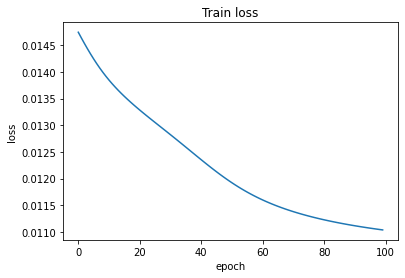

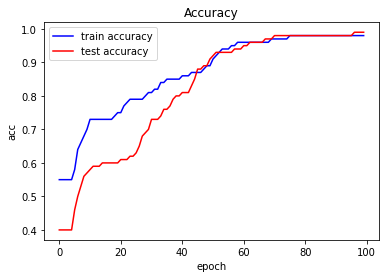

In [17]:
plt.plot(train_losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('Train loss')
plt.show()

plt.plot(score_train, '-b', label='train accuracy')
plt.plot(score_test, '-r', label='test accuracy')
plt.title('Accuracy')
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

In [21]:
class BayesianNeuralNetwork(PyroModule):
    def __init__(self, i, h, o):
        super().__init__()
        #define the first layer
        self.fc1 = PyroModule[nn.Linear](i, h)
        #define the hidden layer
        self.fc2 = PyroModule[nn.Linear](h, o)

        #assume a normal distributions for weight and bias
        self.fc1.weight = PyroSample(dist.Normal(0., 1.)
                                         .expand(self.fc1.weight.shape)
                                         .to_event(self.fc1.weight.dim()))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.)
                                       .expand(self.fc1.bias.shape)
                                       .to_event(self.fc1.bias.dim()))
        
        self.fc2.weight = PyroSample(dist.Normal(0., 1.)
                                         .expand(self.fc2.weight.shape)
                                         .to_event(self.fc2.weight.dim()))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.)
                                       .expand(self.fc2.bias.shape)
                                       .to_event(self.fc2.bias.dim()))
        

    def forward(self, x, y=None):
        #apply tanh activation function
        x = F.tanh(self.fc1(x))
        #apply sigmoid activation function
        x = torch.sigmoid(self.fc2(x)).squeeze()

        size = x.shape[0]
        #sample from the bernoulli distribution
        with pyro.plate('data', size):
            obs = pyro.sample('obs', dist.Bernoulli(probs=x), obs=y)
        
        return x


In [28]:
def train_bayesian(model, X_train, y_train, X_test, y_test, lr, epochs):  
  #clear parameters store
  pyro.clear_param_store()

  #define the criterion
  criterion = nn.BCELoss()
  #define the adam optimizer
  optimizer_bayes = pyro.optim.Adam({"lr": lr})

  svi = SVI(bayesian_model, guide, optimizer_bayes, loss=Trace_ELBO())

  #create a list of train losses to plot
  losses_bayes = []
  #create a list of train acc to plot
  train_scores = []

  #create a list of test losses to plot
  test_scores = []

  for epoch in range(0, epochs):
      loss = svi.step(X_train, y_train)
      #calculate the training loss
      train_loss = loss / len(X_train)
      losses_bayes.append(train_loss)

      # run on 250 samples extracted from the weights distributions 
      predictive = Predictive(bayesian_model, guide=guide, num_samples=250)
      pred_train_bayes = predictive(X_train)['obs'].median(dim=0)[0].int()
      train_score = (pred_train_bayes == y_train).float().mean()
      #calculate train accuracy
      train_scores.append(train_score)

      # run on 250 samples extracted from the weights distributions 
      pred_test_bayes = predictive(X_test)['obs'].median(dim=0)[0].int()
      test_score = (pred_test_bayes == y_test).float().mean()
      #calculate test accuracy
      test_scores.append(test_score)

      print("epoch: {}, train loss: {}, train acc: {}, test acc: {}".format(epoch, train_loss, train_score, test_score))
  #return the train losses and train and test accuracies
  return np.array(losses_bayes), np.array(train_scores), np.array(test_scores)

In [29]:
#define the model
bayesian_model = BayesianNeuralNetwork(2, 2, 1)
#define the guide
guide = AutoNormal(bayesian_model)

In [30]:
#train the model
train_losses, score_train, score_test = train_bayesian(bayesian_model, X_train, y_train, X_test, y_test, 0.05, 70)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch: 0, train loss: 0.8736849725246429, train acc: 0.5600000023841858, test acc: 0.5299999713897705
epoch: 1, train loss: 0.8364580482244491, train acc: 0.6299999952316284, test acc: 0.3499999940395355
epoch: 2, train loss: 0.8579522502422333, train acc: 0.6000000238418579, test acc: 0.46000000834465027
epoch: 3, train loss: 0.8219903177022934, train acc: 0.5799999833106995, test acc: 0.41999998688697815
epoch: 4, train loss: 0.7676018548011779, train acc: 0.5899999737739563, test acc: 0.4300000071525574
epoch: 5, train loss: 0.8302331846952439, train acc: 0.5899999737739563, test acc: 0.41999998688697815
epoch: 6, train loss: 0.784247658252716, train acc: 0.550000011920929, test acc: 0.4000000059604645
epoch: 7, train loss: 0.7948726695775986, train acc: 0.5799999833106995, test acc: 0.44999998807907104
epoch: 8, train loss: 0.7610812997817993, train acc: 0.6000000238418579, test acc: 0.44999998807907104
epoch: 9, train loss: 0.705503693819046, train acc: 0.6899999976158142, test ac

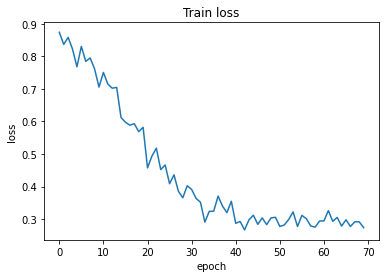

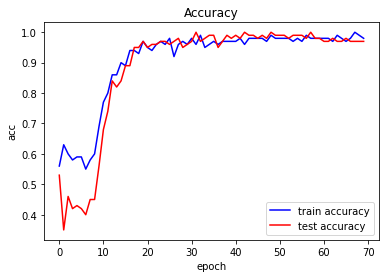

In [31]:
plt.plot(train_losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('Train loss')
plt.show()

plt.plot(score_train, '-b', label='train accuracy')
plt.plot(score_test, '-r', label='test accuracy')
plt.title('Accuracy')
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

Conclusions: looking at the train loss and train/test accuracy plot, it can be easily seen that both model achieve almost the same results with accuracies greater than 97%. However, it takes more time to train the bayesian neural network than the deterministic neural network.

In [32]:
# Sample 250 samples from posterior distribution in order to see how the network converges

predictive = Predictive(bayesian_model, guide=guide, num_samples=250)
predicted = predictive(X_train)

#extract the weights
posterior = []
for i in range(0,2):
  for j in range(0, 2):
    post = 'w' + str(i+1) + str(j+1)
    posterior.append((post, predicted['fc1.weight'][:, 0, i, j].detach().numpy()))

for i in range(0,2):
  post = 'w3' + str(j+1)
  posterior.append((post, predicted['fc2.weight'][:, 0, 0, j].detach().numpy()))


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


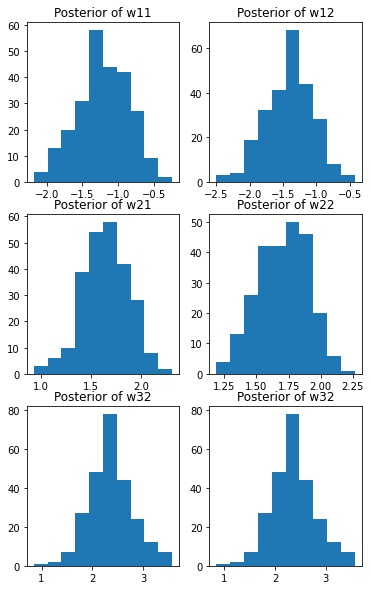

In [34]:
# plot the histograms for each weights
# observation: we get almost the same magnitudes for the pairs wi1 si wi2, with i = {1,2,3}
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(6, 10))

for i in range(len(posterior)):
  post_name, sample = posterior[i]
  ind_x = int(i / 2)
  ind_y = i % 2
  ax[ind_x][ind_y].set_title(f'Posterior of {post_name}')
  ax[ind_x][ind_y].hist(sample)
